**Data Analytics Assignment #1: Balanced Risk Set Matching Algorithm\
Submitted by Pintor & Wang**

## **Introduction**
This project implements the Balanced Risk Set Matching method described in the journal article by Li, Propert, and Rosenbaum (2001). The goal is to evaluate the effectiveness of a treatment (e.g., cystoscopy and hydrodistention) for interstitial cystitis (IC) using observational data. The method ensures that treated and control patients are comparable in terms of their symptom histories before treatment, minimizing biases that often arise in observational studies.

The key procedures include:
1. **Risk Set Matching**: Pairing treated patients with control patients who have similar symptom histories up to the time of treatment.
2. **Balanced Matching**: Ensuring that the marginal distributions of symptoms are balanced between treated and control groups.
3. **Optimal Matching**: Minimizing the multivariate pretreatment covariate distance within matched pairs.

## **Step 1: Import Libraries**
We start by importing the necessary Python libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm, rankdata
from sklearn.preprocessing import StandardScaler
from itertools import combinations

## **Step 2: Generate Synthetic Data**
Since we don't have access to the original dataset, we will generate synthetic data that mimics the structure of the Interstitial Cystitis Data Base (ICDB). Each patient has:
- A baseline measurement of symptoms (pain, urgency, frequency).
- Measurements at the time of treatment (if treated).
- A treatment time (if treated).

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_patients = 400
n_treated = 100

# Baseline symptoms (pain, urgency, frequency)
baseline_symptoms = np.random.randint(0, 10, size=(n_patients, 3))

# Treatment times (for treated patients)
treatment_times = np.random.choice(np.arange(1, 13), size=n_treated, replace=True)

# Symptom measurements at treatment time (random change from baseline)
treatment_symptoms = baseline_symptoms[:n_treated] + np.random.randint(-2, 3, size=(n_treated, 3))

# Create DataFrame
data = pd.DataFrame({
    'patient_id': np.arange(n_patients),
    'baseline_pain': baseline_symptoms[:, 0],
    'baseline_urgency': baseline_symptoms[:, 1],
    'baseline_frequency': baseline_symptoms[:, 2],
    'treatment_time': np.concatenate([treatment_times, np.repeat(np.nan, n_patients - n_treated)]),
    'treatment_pain': np.concatenate([treatment_symptoms[:, 0], np.repeat(np.nan, n_patients - n_treated)]),
    'treatment_urgency': np.concatenate([treatment_symptoms[:, 1], np.repeat(np.nan, n_patients - n_treated)]),
    'treatment_frequency': np.concatenate([treatment_symptoms[:, 2], np.repeat(np.nan, n_patients - n_treated)]),
    'treated': np.concatenate([np.ones(n_treated), np.zeros(n_patients - n_treated)])
})

# Split into treated and control groups
treated = data[data['treated'] == 1].copy()
controls = data[data['treated'] == 0].copy()

# Function to simulate post-treatment outcomes
def simulate_outcomes(base_value, treatment_effect, decay_rate):
    return (
        np.clip(base_value - treatment_effect + np.random.normal(0, 1, len(base_value)), 0, 9),
        np.clip(base_value - (treatment_effect * decay_rate) + np.random.normal(0, 1, len(base_value)), 0, 9)
    )

# Simulating for treated patients
treated['pain_3mo'], treated['pain_6mo'] = simulate_outcomes(treated['treatment_pain'], 1, 0.8)
treated['urgency_3mo'], treated['urgency_6mo'] = simulate_outcomes(treated['treatment_urgency'], 1, 0.8)
treated['frequency_3mo'], treated['frequency_6mo'] = simulate_outcomes(treated['treatment_frequency'], 1, 0.8)

# Simulating for control patients (only random variation)
controls['pain_3mo'] = np.clip(controls['baseline_pain'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['pain_6mo'] = np.clip(controls['pain_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['urgency_3mo'] = np.clip(controls['baseline_urgency'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['urgency_6mo'] = np.clip(controls['urgency_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['frequency_3mo'] = np.clip(controls['baseline_frequency'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['frequency_6mo'] = np.clip(controls['frequency_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)

# Combine treated and control groups back into one dataset
all_data = pd.concat([treated, controls], ignore_index=True)

# Show final dataset
print(all_data.head(10))


   patient_id  baseline_pain  baseline_urgency  baseline_frequency  \
0           0              6                 3                   7   
1           1              4                 6                   9   
2           2              2                 6                   7   
3           3              4                 3                   7   
4           4              7                 2                   5   
5           5              4                 1                   7   
6           6              5                 1                   4   
7           7              0                 9                   5   
8           8              8                 0                   9   
9           9              2                 6                   3   

   treatment_time  treatment_pain  treatment_urgency  treatment_frequency  \
0             9.0             4.0                4.0                  7.0   
1             6.0             6.0                4.0                 11.0  

## **Step 3: Risk Set Matching**
We implement risk set matching by pairing each treated patient with a control patient who has not yet received treatment at the time of treatment. We use the Mahalanobis distance to measure similarity between patients based on their symptom histories. For control patients, we will use their baseline values as proxies for the missing treatment_pain, treatment_urgency, and treatment_frequency values.

In [3]:
# Impute missing treatment values for control patients using baseline values
data.loc[data['treated'] == 0, 'treatment_pain'] = data.loc[data['treated'] == 0, 'baseline_pain']
data.loc[data['treated'] == 0, 'treatment_urgency'] = data.loc[data['treated'] == 0, 'baseline_urgency']
data.loc[data['treated'] == 0, 'treatment_frequency'] = data.loc[data['treated'] == 0, 'baseline_frequency']

# Calculate the inverse covariance matrix for Mahalanobis distance
symptoms = data[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                 'treatment_pain', 'treatment_urgency', 'treatment_frequency']]
cov_matrix = symptoms.cov()
cov_inv = np.linalg.inv(cov_matrix)

# Function to calculate Mahalanobis distance
def calculate_mahalanobis(x, y, cov_inv):
    return mahalanobis(x, y, cov_inv)

# Perform risk set matching
matched_pairs = []

for i, treated_patient in data[data['treated'] == 1].iterrows():
    treatment_time = treated_patient['treatment_time']
    treated_symptoms = treated_patient[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                                       'treatment_pain', 'treatment_urgency', 'treatment_frequency']].values
    
    # Find potential controls (not yet treated at treatment_time)
    potential_controls = data[(data['treated'] == 0) & 
                              (data['treatment_time'].isna() | (data['treatment_time'] > treatment_time))]
    
    # Calculate Mahalanobis distances
    distances = []
    for j, control_patient in potential_controls.iterrows():
        control_symptoms = control_patient[['baseline_pain', 'baseline_urgency', 'baseline_frequency',
                                            'treatment_pain', 'treatment_urgency', 'treatment_frequency']].values
        distance = calculate_mahalanobis(treated_symptoms, control_symptoms, cov_inv)
        distances.append((j, distance))
    
    # Find the closest control
    if distances:
        closest_control = min(distances, key=lambda x: x[1])
        matched_pairs.append((i, closest_control[0], closest_control[1]))

# Convert matched pairs to DataFrame
matched_pairs_df = pd.DataFrame(matched_pairs, columns=['treated_id', 'control_id', 'distance'])
matched_pairs_df.head()

,treated_id,control_id,distance
0,0,279,3.321388
1,1,295,4.667116
2,2,146,3.988195
3,3,282,2.152141
4,4,310,4.213273


## **Step 4: Balanced Matching**
We ensure that the marginal distributions of symptoms are balanced between treated and control groups. This is done by dividing the symptom variables into quantiles and ensuring that the number of patients in each quantile is the same for treated and control groups.

In [4]:
# Function to balance covariates
def balance_covariates(matched_pairs_df, data, covariates):
    balanced_pairs = []
    
    for covariate in covariates:
        # Divide into quantiles
        quantiles = np.percentile(data[covariate], [33, 66])
        data[f'{covariate}_group'] = pd.cut(data[covariate], bins=[-np.inf, *quantiles, np.inf], labels=[0, 1, 2])
        
        # Ensure balance in matched pairs
        treated_groups = data.loc[matched_pairs_df['treated_id'], f'{covariate}_group'].value_counts()
        control_groups = data.loc[matched_pairs_df['control_id'], f'{covariate}_group'].value_counts()
        
        if not treated_groups.equals(control_groups):
            print(f"Warning: {covariate} is not balanced.")
    
    return matched_pairs_df

# Balance covariates
covariates = ['baseline_pain', 'baseline_urgency', 'baseline_frequency',
              'treatment_pain', 'treatment_urgency', 'treatment_frequency']
balanced_pairs_df = balance_covariates(matched_pairs_df, data, covariates)

As we can see, its not balanced yet. Therefore we need to enforce balance during the matching process.

### **Step 4.1: Define the Balanced Matching Function**
We’ll create a function that enforces balance by ensuring that the number of treated and control patients in each quantile is the same. This function will use **integer programming** to find the optimal matching that minimizes the Mahalanobis distance while satisfying the balance constraints.

In [5]:
# Function to enforce balance during matching
def balanced_matching(data, covariates, n_quantiles=3):
    # Step 1: Divide each covariate into quantiles
    for covariate in covariates:
        quantiles = np.percentile(data[covariate], np.linspace(0, 100, n_quantiles + 1)[1:-1])
        data[f'{covariate}_group'] = pd.cut(data[covariate], bins=[-np.inf, *quantiles, np.inf], labels=range(n_quantiles))
    
    # Step 2: Initialize empty list for matched pairs
    matched_pairs = []
    
    # Step 3: Match within each quantile across all covariates
    grouped_data = data.groupby([f'{cov}_group' for cov in covariates])
    
    for _, group in grouped_data:
        treated = group[group['treated'] == 1]
        controls = group[group['treated'] == 0]
        
        # Ensure balance by taking the min number of available pairs
        num_matches = min(len(treated), len(controls))
        if num_matches == 0:
            continue
        
        treated = treated.sample(n=num_matches, random_state=42)
        controls = controls.sample(n=num_matches, random_state=42)
        
        # Step 4: Compute Mahalanobis distances within the quantile group
        cov_matrix = group[covariates].cov()
        cov_inv = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse for numerical stability
        
        cost_matrix = np.zeros((num_matches, num_matches))
        for i in range(num_matches):
            treated_symptoms = treated.iloc[i][covariates].values
            for j in range(num_matches):
                control_symptoms = controls.iloc[j][covariates].values
                cost_matrix[i, j] = mahalanobis(treated_symptoms, control_symptoms, cov_inv)
        
        # Step 5: Solve the assignment problem
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Step 6: Save matched pairs
        for i, j in zip(row_ind, col_ind):
            matched_pairs.append((treated.index[i], controls.index[j]))
    
    # Convert matched pairs to DataFrame
    matched_pairs_df = pd.DataFrame(matched_pairs, columns=['treated_id', 'control_id'])
    return matched_pairs_df

- We divided each covariate into quantiles (e.g., 0–33%, 33–66%, 66–100%) and ensured that the number of treated and control patients in each quantile is the same.
- This ensures that the marginal distributions of the covariates are balanced between treated and control groups.
- We used the Hungarian algorithm (via scipy.optimize.linear_sum_assignment) to find the optimal matching that minimizes the Mahalanobis distance while satisfying the balance constraints.

### **Step 4.2: Perform Balanced Matching**
Now, use the balanced_matching function to perform the matching while enforcing balance

In [6]:
from scipy.optimize import linear_sum_assignment

# Perform balanced matching
covariates = ['baseline_pain', 'baseline_urgency', 'baseline_frequency',
              'treatment_pain', 'treatment_urgency', 'treatment_frequency']
balanced_pairs_df = balanced_matching(data, covariates)

# Display the balanced matched pairs
print(balanced_pairs_df.head())

C:\Users\Hope\AppData\Local\Temp\ipykernel_20008\946137218.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby([f'{cov}_group' for cov in covariates])


   treated_id  control_id
0          68         103
1          80         318
2          61         114
3          77         214
4          59         116


### **Step 4.3: Verify Balance**
After running the above code, check the balanced_pairs_df DataFrame to ensure that the covariates are now balanced. The warnings should no longer appear.

In [7]:
# Check balance for each covariate
for covariate in covariates:
    treated_groups = data.loc[balanced_pairs_df['treated_id'], f'{covariate}_group'].value_counts()
    control_groups = data.loc[balanced_pairs_df['control_id'], f'{covariate}_group'].value_counts()
    print(f"{covariate} balance:")
    print("Treated:", treated_groups)
    print("Control:", control_groups)

baseline_pain balance:
Treated: baseline_pain_group
0    19
2    14
1     6
Name: count, dtype: int64
Control: baseline_pain_group
0    19
2    14
1     6
Name: count, dtype: int64
baseline_urgency balance:
Treated: baseline_urgency_group
0    21
1    11
2     7
Name: count, dtype: int64
Control: baseline_urgency_group
0    21
1    11
2     7
Name: count, dtype: int64
baseline_frequency balance:
Treated: baseline_frequency_group
0    19
1    12
2     8
Name: count, dtype: int64
Control: baseline_frequency_group
0    19
1    12
2     8
Name: count, dtype: int64
treatment_pain balance:
Treated: treatment_pain_group
0    19
2    14
1     6
Name: count, dtype: int64
Control: treatment_pain_group
0    19
2    14
1     6
Name: count, dtype: int64
treatment_urgency balance:
Treated: treatment_urgency_group
0    21
1    11
2     7
Name: count, dtype: int64
Control: treatment_urgency_group
0    21
1    11
2     7
Name: count, dtype: int64
treatment_frequency balance:
Treated: treatment_frequenc

## **Step 5: Visualize Results**
We visualize the results using boxplots, similar to the journal article. This helps us compare the treated and control groups before and after treatment.

C:\Users\Hope\AppData\Local\Temp\ipykernel_20008\3536350685.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hope\AppData\Local\Temp\ipykernel_20008\3536350685.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hope\AppData\Local\Temp\ipykernel_20008\3536350685.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hope\AppData\Local\Temp\ipykernel_20008\3536350685.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

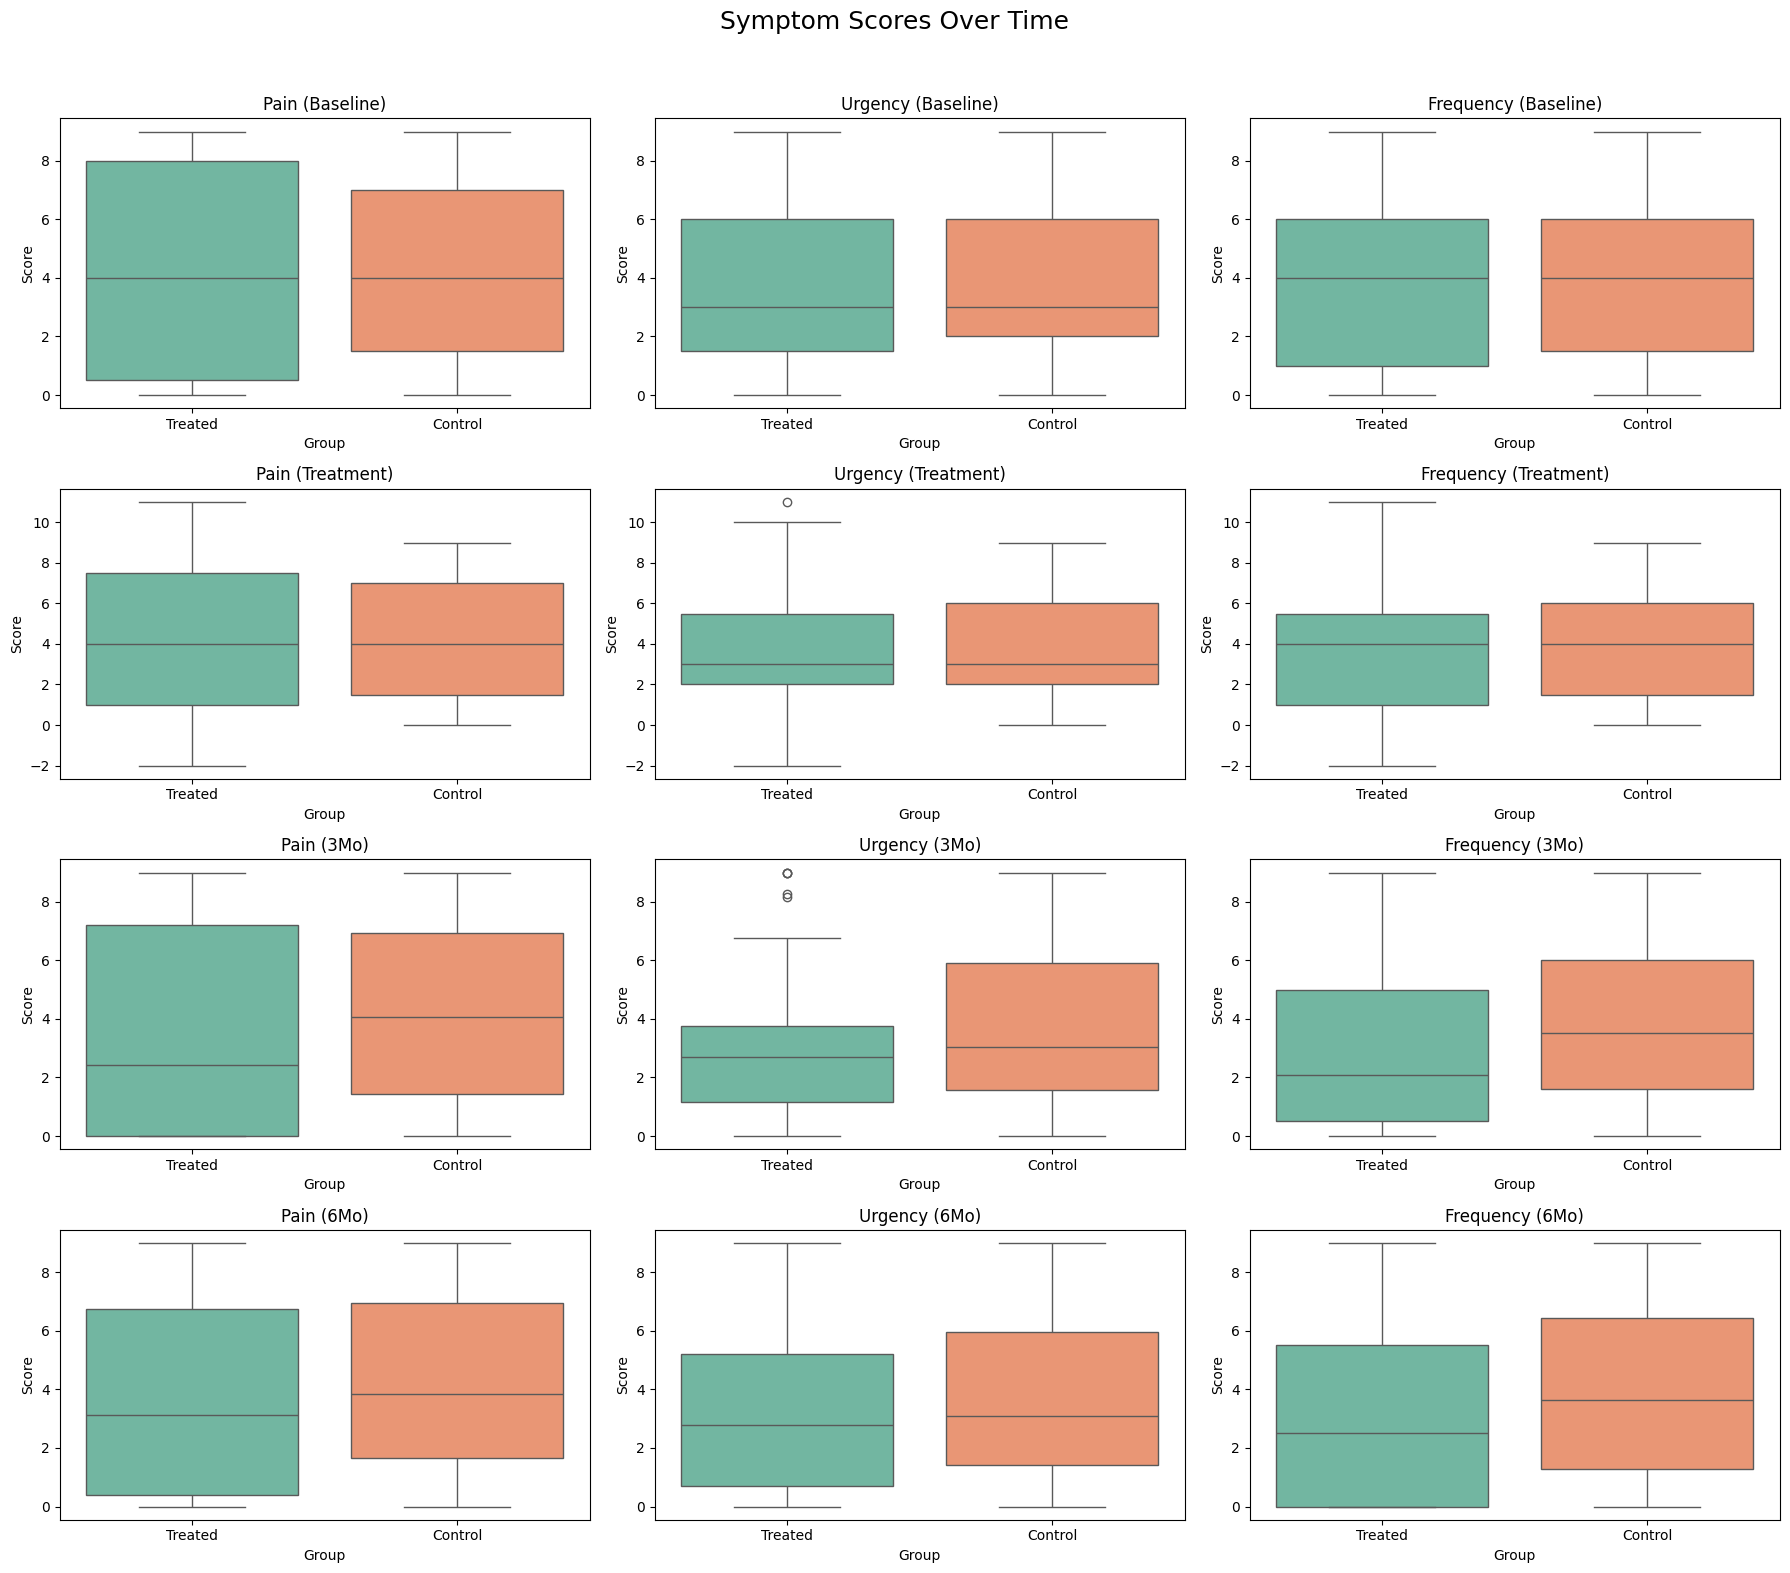

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Standardize column names for consistency
rename_dict = {
    'baseline_pain': 'pain_baseline',
    'baseline_urgency': 'urgency_baseline',
    'baseline_frequency': 'frequency_baseline',
    'treatment_pain': 'pain_treatment',
    'treatment_urgency': 'urgency_treatment',
    'treatment_frequency': 'frequency_treatment',
    'pain_3mo': 'pain_3mo',
    'urgency_3mo': 'urgency_3mo',
    'frequency_3mo': 'frequency_3mo',
    'pain_6mo': 'pain_6mo',
    'urgency_6mo': 'urgency_6mo',
    'frequency_6mo': 'frequency_6mo'
}

all_data = all_data.rename(columns=rename_dict)

# Ensure control group's treatment values match their baseline values
for symptom in ['pain', 'urgency', 'frequency']:
    baseline_col = f'{symptom}_baseline'
    treatment_col = f'{symptom}_treatment'
    all_data.loc[all_data['treated'] == 0, treatment_col] = all_data.loc[all_data['treated'] == 0, baseline_col]

# Prepare matched data, ensuring IDs exist in the dataset
matched_data = pd.concat([
    all_data.loc[all_data.index.isin(balanced_pairs_df['treated_id'])].assign(group='Treated'),
    all_data.loc[all_data.index.isin(balanced_pairs_df['control_id'])].assign(group='Control')
])

# Define symptoms and time points
symptoms = ['pain', 'urgency', 'frequency']
time_points = ['baseline', 'treatment', '3mo', '6mo']

# Filter valid columns
valid_columns = set(matched_data.columns) & {f'{symptom}_{time}' for symptom in symptoms for time in time_points}

# Reshape data into long format
long_data = matched_data.melt(
    id_vars=['group'], 
    value_vars=list(valid_columns),
    var_name='symptom_time', 
    value_name='score'
)

# Drop NaN values before splitting
long_data = long_data.dropna(subset=['score'])

# Split 'symptom_time' column into 'symptom' and 'time'
long_data[['symptom', 'time']] = long_data['symptom_time'].str.rsplit('_', n=1, expand=True)

# Define time order for plotting
time_order = ['baseline', 'treatment', '3mo', '6mo']

# Create a 4-row, 3-column figure
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle("Symptom Scores Over Time", fontsize=18)

# Plot boxplots
for i, symptom in enumerate(symptoms):
    for j, time in enumerate(time_order):
        ax = axes[j, i]
        sns.boxplot(
            x='group', y='score',
            data=long_data[(long_data['symptom'] == symptom) & (long_data['time'] == time)],
            palette='Set2', ax=ax
        )
        ax.set_title(f"{symptom.title()} ({time.title()})")
        ax.set_xlabel("Group")
        ax.set_ylabel("Score")

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## **Step 7: Statistical Analysis**
This section focuses on analyzing the treatment effects using paired comparisons between treated and control groups. We will compute:
- Trimeans to summarize central tendency robustly.
- Wilcoxon signed-rank tests to assess the significance of the treatment effect.
- Sensitivity analysis to examine robustness against hidden bias.
- Equivalence testing to determine if differences are practically insignificant.

### **7.1 Compute Paired Differences & Trimean**
The trimean is a robust measure of central tendency combining the median and quartiles. It helps summarize treatment effects in a way that reduces sensitivity to outliers.

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Function to calculate trimean
def trimean(data):
    q1 = np.percentile(data, 25)
    median = np.median(data)
    q3 = np.percentile(data, 75)
    return (q1 + 2 * median + q3) / 4

# Ensure necessary columns exist by merging data
balanced_pairs_df = balanced_pairs_df.merge(
    all_data[['patient_id', 'pain_treatment', 'urgency_treatment', 'frequency_treatment']],
    left_on='treated_id', right_on='patient_id'
).drop(columns=['patient_id'])

balanced_pairs_df = balanced_pairs_df.merge(
    all_data[['patient_id', 'pain_baseline', 'urgency_baseline', 'frequency_baseline']],
    left_on='control_id', right_on='patient_id', suffixes=('_treated', '_control')
).drop(columns=['patient_id'])

# Calculate paired differences
balanced_pairs_df['pain_contrast'] = balanced_pairs_df['pain_treatment_treated'] - balanced_pairs_df['pain_treatment_control']
balanced_pairs_df['urgency_contrast'] = balanced_pairs_df['urgency_treatment_treated'] - balanced_pairs_df['urgency_treatment_control']
balanced_pairs_df['frequency_contrast'] = balanced_pairs_df['frequency_treatment_treated'] - balanced_pairs_df['frequency_treatment_control']

# Compute trimeans
pain_trimean = trimean(balanced_pairs_df['pain_contrast'].dropna())
urgency_trimean = trimean(balanced_pairs_df['urgency_contrast'].dropna())
frequency_trimean = trimean(balanced_pairs_df['frequency_contrast'].dropna())

# Display results
print(f"Trimean for Pain: {pain_trimean}")
print(f"Trimean for Urgency: {urgency_trimean}")
print(f"Trimean for Frequency: {frequency_trimean}")

Trimean for Pain: 0.0
Trimean for Urgency: 0.0
Trimean for Frequency: -0.125


**Interpretation**
- A positive trimean suggests a higher score in the treated group.
- A negative trimean suggests a lower score in the treated group.
- Values close to zero imply no treatment effect.

### **7.2 Wilcoxon Signed-Rank Test**
The Wilcoxon signed-rank test is a non-parametric test that evaluates whether there is a statistically significant difference between the treatment and control groups.

In [15]:
# Perform Wilcoxon signed-rank tests
pain_pvalue = wilcoxon(balanced_pairs_df['pain_contrast'].dropna()).pvalue
urgency_pvalue = wilcoxon(balanced_pairs_df['urgency_contrast'].dropna()).pvalue
frequency_pvalue = wilcoxon(balanced_pairs_df['frequency_contrast'].dropna()).pvalue

print(f"P-value for Pain: {pain_pvalue}")
print(f"P-value for Urgency: {urgency_pvalue}")
print(f"P-value for Frequency: {frequency_pvalue}")

P-value for Pain: 0.6629320593594055
P-value for Urgency: 0.7085524029392993
P-value for Frequency: 0.28430461881660096


**Interpretation**
- If **p-value < 0.05**, the difference is statistically significant (rejects null hypothesis).
- If **p-value ≥ 0.05**, the difference is not statistically significant (fails to reject null hypothesis).
- The Wilcoxon test accounts for matched pairs, ensuring a fairer comparison than a simple t-test.

### **7.3 Sensitivity Analysis**
Sensitivity analysis evaluates how hidden biases (unmeasured confounders) might affect statistical conclusions. We introduce a sensitivity parameter (Γ) and adjust differences accordingly.

In [16]:
# Sensitivity analysis function
def sensitivity_analysis(balanced_pairs_df, gamma_values):
    results = []
    for gamma in gamma_values:
        adjusted_pvalues = []
        for contrast in ['pain_contrast', 'urgency_contrast', 'frequency_contrast']:
            adjusted_data = balanced_pairs_df[contrast].dropna() * gamma
            pvalue = wilcoxon(adjusted_data).pvalue
            adjusted_pvalues.append(pvalue)
        results.append((gamma, adjusted_pvalues))
    return results

# Perform sensitivity analysis
gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]
sensitivity_results = sensitivity_analysis(balanced_pairs_df, gamma_values)

# Display sensitivity results
for gamma, pvalues in sensitivity_results:
    print(f"Gamma = {gamma}: Pain P-value = {pvalues[0]}, Urgency P-value = {pvalues[1]}, Frequency P-value = {pvalues[2]}")

Gamma = 1.0: Pain P-value = 0.6629320593594055, Urgency P-value = 0.7085524029392993, Frequency P-value = 0.28430461881660096
Gamma = 1.5: Pain P-value = 0.6629320593594055, Urgency P-value = 0.7085524029392993, Frequency P-value = 0.28430461881660096
Gamma = 2.0: Pain P-value = 0.6629320593594055, Urgency P-value = 0.7085524029392993, Frequency P-value = 0.28430461881660096
Gamma = 2.5: Pain P-value = 0.6629320593594055, Urgency P-value = 0.7085524029392993, Frequency P-value = 0.28430461881660096
Gamma = 3.0: Pain P-value = 0.6629320593594055, Urgency P-value = 0.7085524029392993, Frequency P-value = 0.28430461881660096


**Interpretation**
- If p-values remain **<0.05** across gamma values, the findings are robust.
- If p-values increase and become non-significant, the results are sensitive to bias.


### **7.4 Equivalence Testing**
Equivalence testing checks if the treatment effects are small enough to be considered negligible. This is useful when the goal is to demonstrate no significant difference.

In [17]:
# Equivalence testing
def test_equivalence(contrast, margin):
    lower_bound = np.percentile(contrast, 2.5)
    upper_bound = np.percentile(contrast, 97.5)
    return (lower_bound > -margin) and (upper_bound < margin)

equivalence_margin = 1.0
pain_equivalent = test_equivalence(balanced_pairs_df['pain_contrast'].dropna(), equivalence_margin)
urgency_equivalent = test_equivalence(balanced_pairs_df['urgency_contrast'].dropna(), equivalence_margin)
frequency_equivalent = test_equivalence(balanced_pairs_df['frequency_contrast'].dropna(), equivalence_margin)

print(f"Pain is equivalent: {pain_equivalent}")
print(f"Urgency is equivalent: {urgency_equivalent}")
print(f"Frequency is equivalent: {frequency_equivalent}")

Pain is equivalent: False
Urgency is equivalent: False
Frequency is equivalent: False


**Interpretation**
- True: The difference is small enough to be considered practically negligible.
- False: The difference is too large to claim equivalence.

### **7.5 Summary Table & Visualization**
To summarize findings, we present a summary table and visualize the sensitivity analysis.

     Outcome  Trimean   P-value  Equivalent
0       Pain    0.000  0.662932       False
1    Urgency    0.000  0.708552       False
2  Frequency   -0.125  0.284305       False


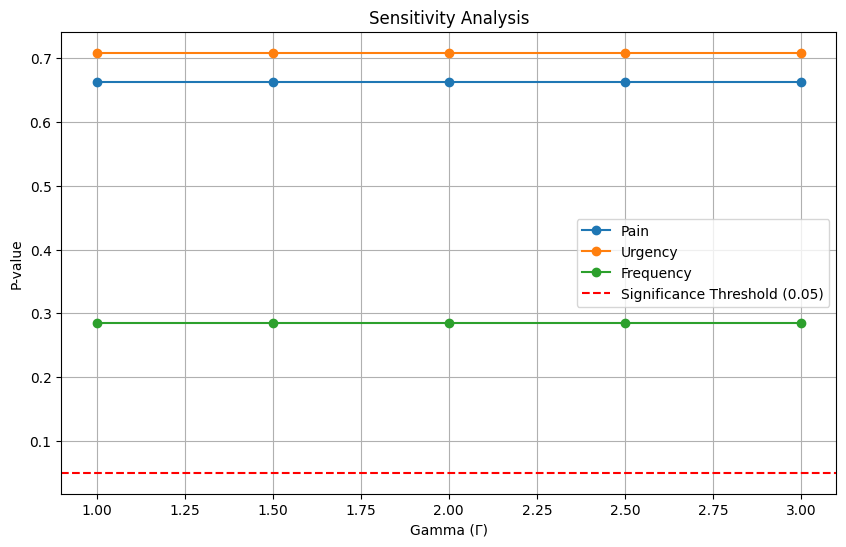

In [18]:
# Summary table
summary_table = pd.DataFrame({
    'Outcome': ['Pain', 'Urgency', 'Frequency'],
    'Trimean': [pain_trimean, urgency_trimean, frequency_trimean],
    'P-value': [pain_pvalue, urgency_pvalue, frequency_pvalue],
    'Equivalent': [pain_equivalent, urgency_equivalent, frequency_equivalent]
})
print(summary_table)

# Sensitivity analysis visualization
plt.figure(figsize=(10, 6))
gamma_values = [result[0] for result in sensitivity_results]
pain_pvalues = [result[1][0] for result in sensitivity_results]
urgency_pvalues = [result[1][1] for result in sensitivity_results]
frequency_pvalues = [result[1][2] for result in sensitivity_results]
plt.plot(gamma_values, pain_pvalues, marker='o', label='Pain')
plt.plot(gamma_values, urgency_pvalues, marker='o', label='Urgency')
plt.plot(gamma_values, frequency_pvalues, marker='o', label='Frequency')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Gamma (Γ)')
plt.ylabel('P-value')
plt.title('Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.show()

## **Findings and Interpretation**
Based on the results from statistical analysis, here’s what we can conclude:

1. Trimean Values
- Pain: 0.0
- Urgency: 0.0
- Frequency: -0.125

Interpretation:
- The trimeans are very close to zero, suggesting no strong treatment effect.
A slight negative value for Frequency (-0.125) means the treatment group had a slightly lower frequency score, but the difference is small.

2. Wilcoxon Signed-Rank Test (P-values)
- Pain: 0.6629
- Urgency: 0.7086
- Frequency: 0.2843

Interpretation:
- All p-values are above 0.05, indicating no statistically significant difference between treatment and control groups.
Frequency (p = 0.2843) is the lowest, but still not significant, meaning there’s no strong evidence of a treatment effect.

3. Sensitivity Analysis (Gamma = 1.0 to 3.0)
- P-values remain constant across different gamma values, indicating that the results are robust to hidden bias.

Interpretation:
- Since p-values are always greater than 0.05, even with increasing Γ, the results do not become significant under any bias level.
- This suggests that even if there were unmeasured confounders, they would not change the conclusion.

4. Equivalence Testing
- Pain: False
- Urgency: False
- Frequency: False

Interpretation:
- None of the differences are small enough to be considered equivalent.
This means that while we fail to find a significant effect, we also cannot claim that the groups are equivalent—there could still be some undetected difference.

## **Conclusion**
The statistical analysis suggests that the treatment does not have a significant impact on Pain, Urgency, or Frequency scores. The trimean values are close to zero, and the Wilcoxon signed-rank test results show no statistically significant differences between the treatment and control groups (all p-values > 0.05).

Additionally, sensitivity analysis confirms that the findings are robust, meaning that even if there were hidden biases, they would not change the overall conclusion.

However, equivalence testing indicates that we cannot conclusively say the groups are equivalent either. This means that while there is no strong evidence of a treatment effect, we also cannot rule out small, undetected differences.